# Grad-CAM

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

import cv2
import torch

import glob

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Helper functions
import sys
sys.path.append('../')

from utils.datasets import ImageDataset
from utils.visualise import get_edge

# Load model and dataset

In [2]:
# Download the model using torch hub
model = torch.hub.load('conorosully/XAI-for-CV-models', 'pot_plant_classifier')

# Set the model to evaluation mode
device = torch.device('mps' if torch.backends.mps.is_built()
                      else 'cuda' if torch.cuda.is_available()
                      else 'cpu')
model.to(device)
model.eval()

Using cache found in /Users/conorosullivan/.cache/torch/hub/conorosully_XAI-for-CV-models_main


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=65536, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=4, bias=True)
  )
)

In [3]:
base_path = "../../data/pot_plants/"

plant_names = ['rudo','baya','greg','yuki']
num_classes = len(plant_names)

# Load the data
test_paths = glob.glob(base_path + "/test/*.jpg")
test_data = ImageDataset(test_paths,num_classes)

Figure saved to /Users/conorosullivan/Documents/XAI/GradCAM_incorrect_prediction.pdf


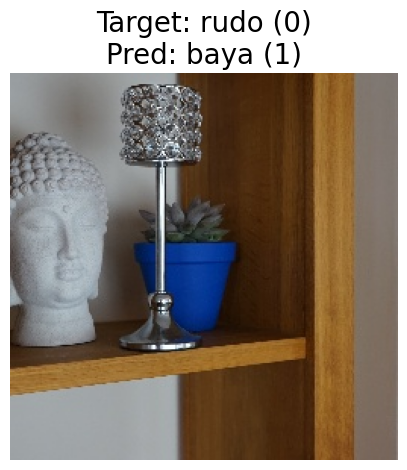

In [4]:
# Get random instance
image, target = test_data.__getitem__(3) # i = 10, 3

# Format target
target = torch.argmax(target).item()
target_name = plant_names[target]

# Get prediction
input = image.unsqueeze(0).to(device)
output = model(input)
pred = torch.argmax(output).item()
pred_name = plant_names[pred]

# Diplay prediction
rgb_image = image.permute(1,2,0).numpy ()
plt.imshow(rgb_image)
plt.title(f"Target: {target_name} ({target})\nPred: {pred_name} ({pred})")
plt.axis('off')

## Canny edge detection

Figure saved to /Users/conorosullivan/Documents/XAI/GradCAM_canny_example.pdf


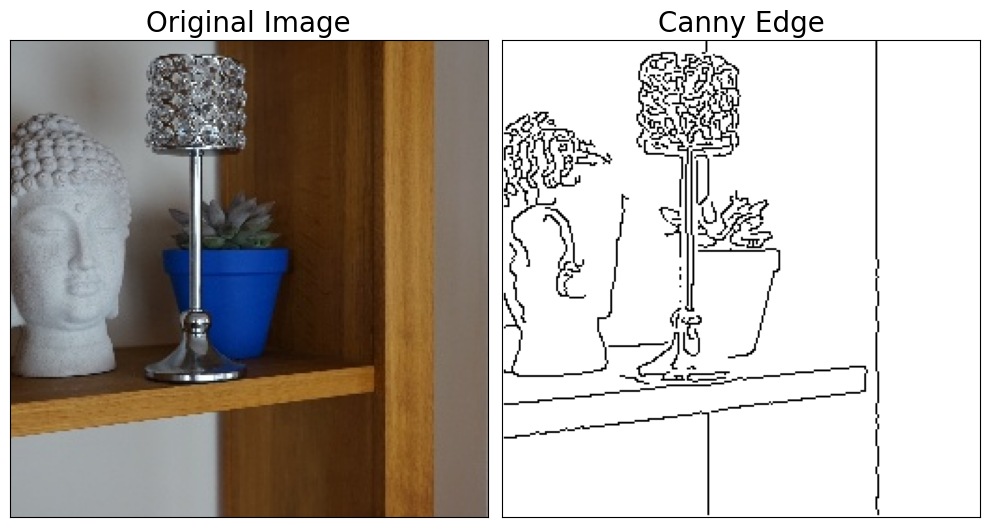

In [5]:
def get_canny_edge(img,threshold1=30,threshold2=80):

    """
    Replaced by get_edge in visualise.py
    """

    print()

fig, ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(rgb_image)
ax[0].set_title("Original Image")

edge= get_edge(rgb_image, sigma=1, as_image=True)

ax[1].imshow(edge, cmap='gray')
ax[1].set_title("Canny Edge")

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

In [6]:
def plot_gradcam(rgb_image, visulaization,title='Input'):

    """Display the original image and the GradCAM heatmap"""

    fig, ax = plt.subplots(1,2,figsize=(10,5))

    ax[0].imshow(rgb_image)
    ax[0].set_title(title)

    ax[1].imshow(visulaization)
    ax[1].set_title("GradCAM Heatmap")

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

## GradCAM

In [7]:
# Define the target layer and class of interest
classes = [ClassifierOutputTarget(1)]
layers = [model.conv_layers[6]]

(1, 256, 256)
Figure saved to /Users/conorosullivan/Documents/XAI/GradCAM_raw_heatmap.pdf


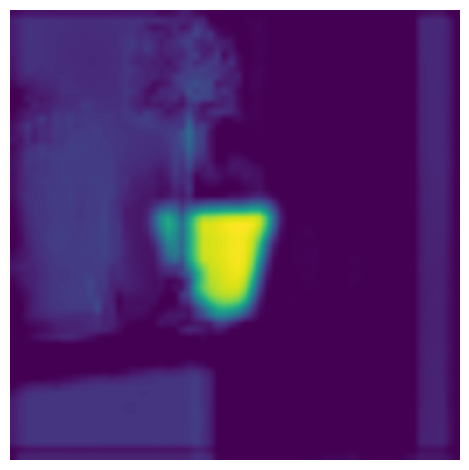

In [8]:
# Get the GradCAM heatmap
cam = GradCAM(model=model, target_layers=layers)
heatmap = cam(input_tensor=image.unsqueeze(0), targets=classes)

print(heatmap.shape)

plt.imshow(heatmap[0])
plt.axis('off')

Figure saved to /Users/conorosullivan/Documents/XAI/GradCAM_heatmap_conv3.pdf


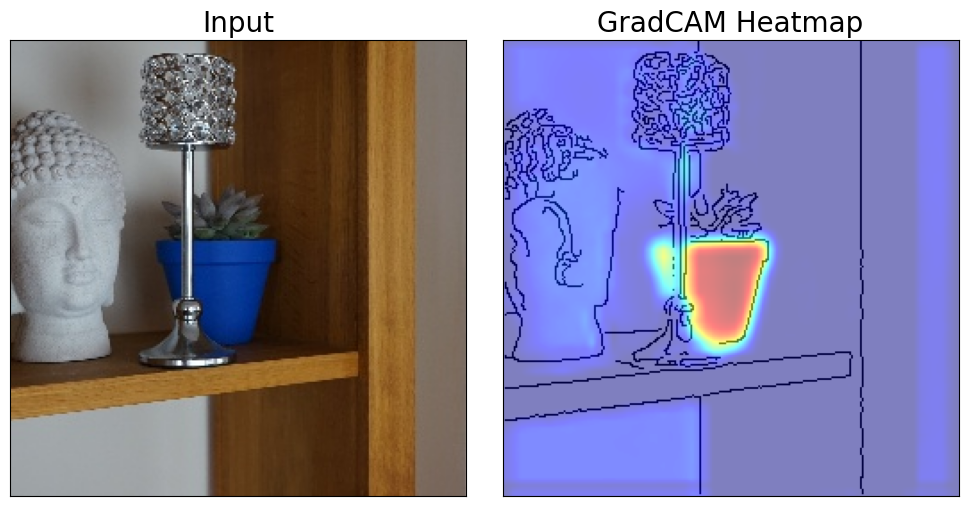

In [9]:
# Plot the heatmap
edge = get_edge(rgb_image, sigma=1, as_image=True)
visulaization = show_cam_on_image(edge, heatmap[0], use_rgb=True)

plot_gradcam(rgb_image, visulaization)

### Multiple layers

In [10]:
# all conv layers
layers = [model.conv_layers[0],model.conv_layers[3],model.conv_layers[6]]

Figure saved to /Users/conorosullivan/Documents/XAI/GradCAM_heatmap_all_conv.pdf


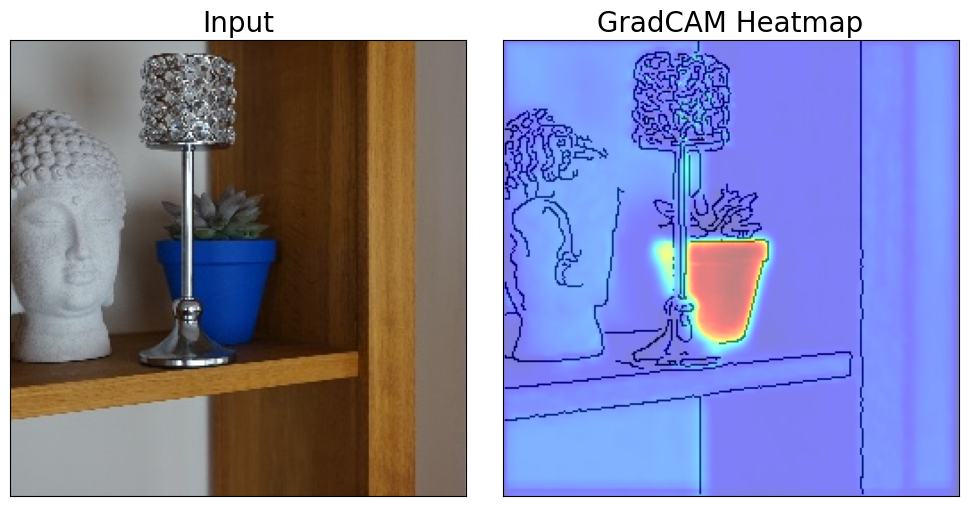

In [11]:
# Get combined heatmap for all layers
cam = GradCAM(model=model, target_layers=layers)
heatmap = cam(input_tensor=image.unsqueeze(0), targets=classes)

# Plot the heatmap
edge = get_edge(rgb_image, sigma=1, as_image=True)
visulaization = show_cam_on_image(edge, heatmap[0], use_rgb=True)
plot_gradcam(rgb_image, visulaization)

Figure saved to /Users/conorosullivan/Documents/XAI/GradCAM_heatmap_seperate_conv.pdf


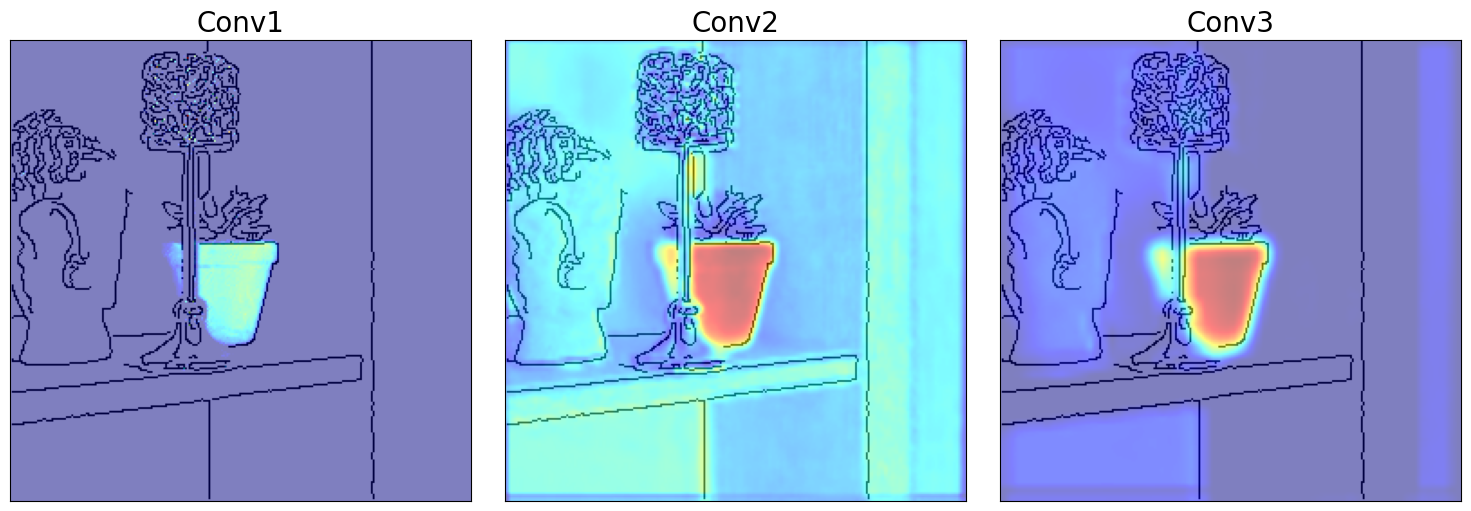

In [12]:
# Get seperate visualizations for each layer
maps = []
for layer in layers:
    cam = GradCAM(model=model, target_layers=[layer])
    heatmap = cam(input_tensor=image.unsqueeze(0), targets=classes)
    visulaization = show_cam_on_image(edge, heatmap[0], use_rgb=True)
    maps.append(visulaization)

fig, ax = plt.subplots(1,3,figsize=(15,5))

for i,vis in enumerate(maps):
    ax[i].imshow(vis)
    ax[i].set_title(f"Conv{i+1}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

# Multiple classes

(1, 256, 256)
Figure saved to /Users/conorosullivan/Documents/XAI/GradCAM_heatmap_mutli_class.pdf


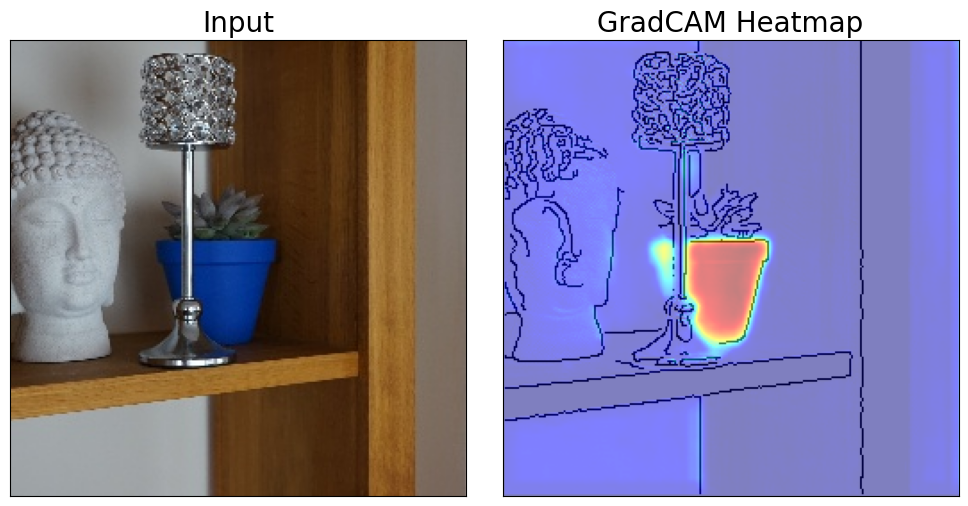

In [13]:
# Define target classes
classes = [ClassifierOutputTarget(0),
           ClassifierOutputTarget(1),
           ClassifierOutputTarget(2),
           ClassifierOutputTarget(3)]

# Get the GradCAM heatmap
cam = GradCAM(model=model, target_layers=layers)
heatmap = cam(input_tensor=image.unsqueeze(0), targets=classes)

print(heatmap.shape)

# Plot the heatmap
edge = get_edge(rgb_image, sigma=1, as_image=True)
visulaization = show_cam_on_image(edge, heatmap[0], use_rgb=True)

plot_gradcam(rgb_image, visulaization)

In [14]:
# Output scores
print(output)

tensor([[-2.9944,  9.6644, -0.2042, -2.6261]], device='mps:0',
       grad_fn=<LinearBackward0>)


### Other classes

Figure saved to /Users/conorosullivan/Documents/XAI/GradCAM_heatmap_class_0.pdf
Figure saved to /Users/conorosullivan/Documents/XAI/GradCAM_heatmap_class_1.pdf
Figure saved to /Users/conorosullivan/Documents/XAI/GradCAM_heatmap_class_2.pdf
Figure saved to /Users/conorosullivan/Documents/XAI/GradCAM_heatmap_class_3.pdf


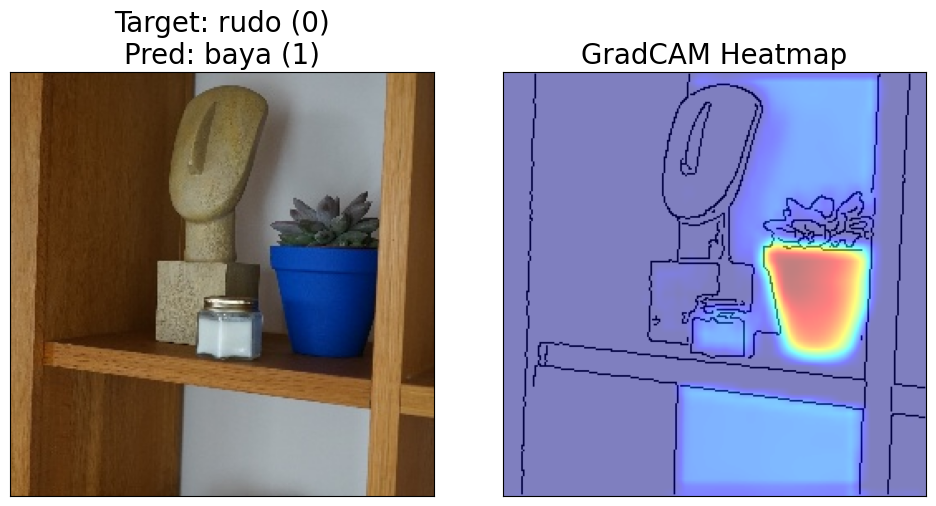

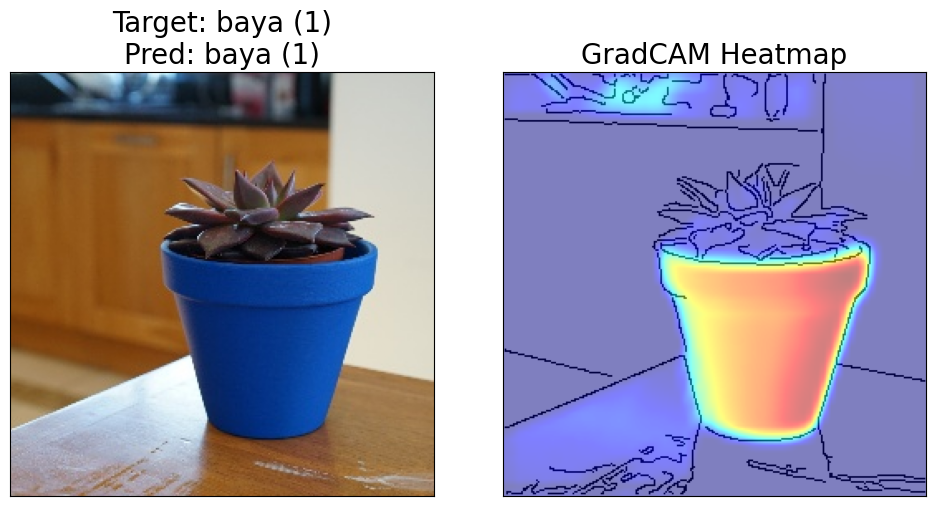

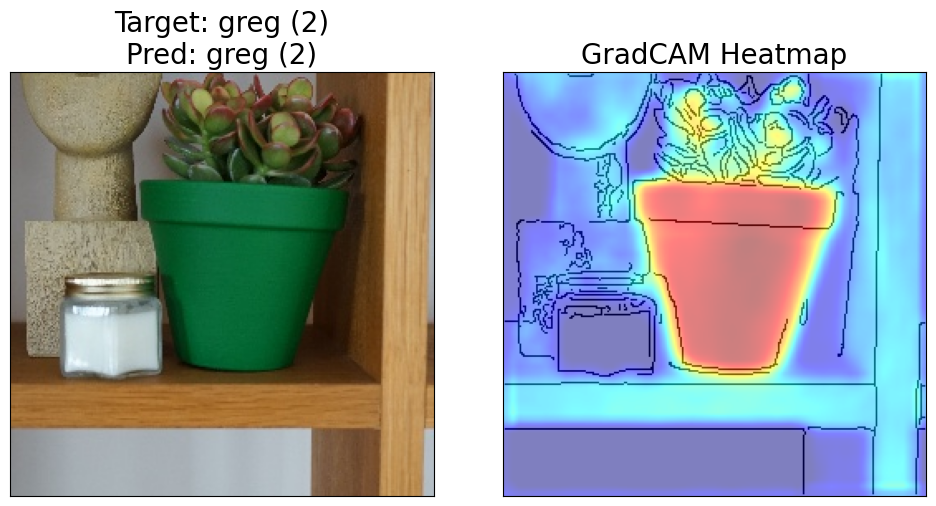

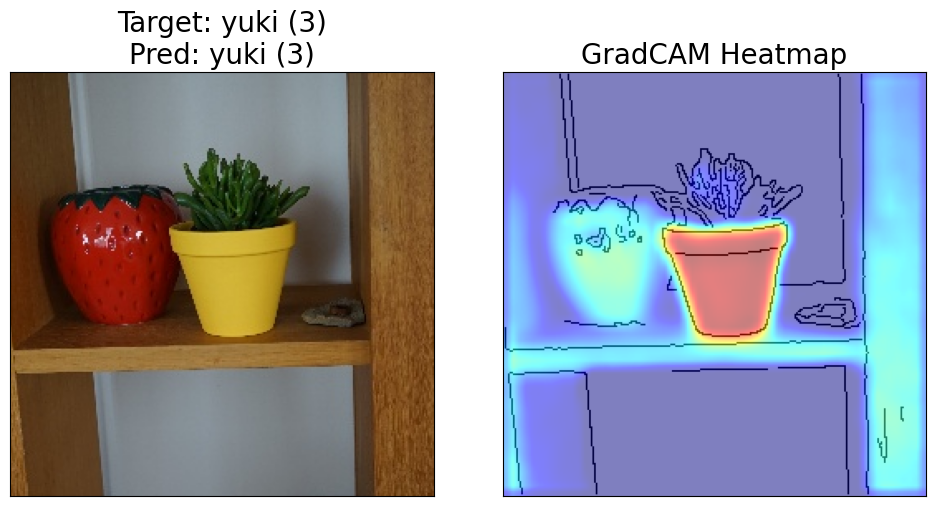

In [17]:
for p in [0,1,2,3]:

    # Get the paths for given class
    paths = glob.glob(base_path + "/test/{}_*.jpg".format(p))

    # Get random instance
    np.random.shuffle(paths)
    data = ImageDataset(paths,num_classes=num_classes)
    image, target = data.__getitem__(0)

    # Format target
    target = torch.argmax(target).item()

    # Get prediction
    input = image.unsqueeze(0).to(device)
    output = model(input)
    pred = torch.argmax(output).item()

    # Use prediction as target class
    classes = [ClassifierOutputTarget(pred)]
    layers = [model.conv_layers[6]]

    # Get heatmap
    cam = GradCAM(model=model, target_layers=layers)
    heatmap = cam(input_tensor=image.unsqueeze(0), targets= classes)

    # Display
    rgb_image = image.permute(1,2,0).numpy()
    edge = get_edge(rgb_image, sigma=1, as_image=True)
    visulaization = show_cam_on_image(edge, heatmap[0], use_rgb=True)

    title = f"Target: {plant_names[target]} ({target})\nPred: {plant_names[pred]} ({pred})"
    plot_gradcam(rgb_image, visulaization,title)